In [97]:
import gensim
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import os, json
import numpy as np
from my_utils import *

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize.casual import TweetTokenizer
from collections import Counter

WORD_EMBEDDING_DIMENSIONALITY = 200
UTTERANCE_DIMENSIONALITY = 200
MAX_TURNS = 21

num_to_label = {0:'NB', 1:'PB', 2:'B', 3:'U'}
label_to_num = {'NB':0, "PB":1, 'B':2, 'U':3}

NB_LABELS = len(num_to_label)

In [122]:
import json
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize.casual import TweetTokenizer
from collections import Counter


#####################################
# file path -> array
#####################################
def json_file_path_to_array(json_file_path):
    '''Takes path to json file and return its dialogue as an array of turns'''
    with open(json_file_path) as json_f:
        d = json.load(json_f)
    parsed = []
    def parse_turn(turn):
        '''parse turn, separate utterances and labels'''
        utterance = turn['utterance']
        if not turn['annotations']:
            return utterance
        else:
            breakdown_l = [annotation['breakdown'] for annotation in turn['annotations']]
            return (utterance, breakdown_l)    
    for t in d['turns']:
        parsed.append(parse_turn(t))
    return parsed

#####################################
# array of labels -> score
#####################################
def dialogue_array_score(dialogue):
    '''Tranform 30 labels of each system response into one majority score'''
    # print('scoring labels of the dialogue - ', dialogue)
    for i, turn in enumerate(dialogue):
        if isinstance(turn, tuple):
            local_turn, labels = dialogue[i]
            NB = labels.count('O')
            PB = labels.count('X')
            B = labels.count('T')
            counts_array = np.array([NB, PB, B])
            final_label = np.argmax(counts_array)
            print('assign label {} to turn {}'.format(final_label, local_turn))
            dialogue[i] = (local_turn, final_label)
    return dialogue


# separate labels and utterances
def separate_turns_labels(dialogue):
    '''takes a dialogue array with labelled system responses as an input and
    returns arrays of its utterances and corresponding labels'''
    utterances = []
    labels = []
    print('working on dialogue  - ', dialogue)
    for t in dialogue:
        if isinstance(t,tuple):
            print('its system turn! label - ', t[1])
            utterances.append(t[0])
            labels.append(t[1])
        else:
            print("user's turn!")
            utterances.append(t)
            labels.append(label_to_num['U'])
        print('final labels - ', labels)
    return utterances, labels


def tokens_replacement(tokens):
    '''
    the function replaces some of the hyphenated tokens with more appropariate counterparts
    '''
    replacement_dict = dict({
    "That's": 'That is',
    "that's": 'that is',
    "What's": 'What is',
    "what's": 'what is',
    "Let's": 'Lets',
    "let's": 'lets',
    "that's": 'that is',
    "You're": 'You are',
    "you're": 'you are',
    "i'm" : 'I am',
    "I'm" : 'I am',
    "i'm": "I'm",
    "isn't": "is not",
    "haven't": "have not",
    "wasn't": "was not",
    "wouldn't": "would not",
    "shouldn't": "should not",
    "there's": "there is",
    "They're": "They are",
    "they're": "they're",
    "we're": "we are",
    "don't" : "do not"
    })
    
    for i, token in enumerate(tokens):
        if token in replacement_dict:
            # print('token ', token, ' needs to be replaced')
            del tokens[i]
            replacement = TweetTokenizer().tokenize(replacement_dict[token])
            tokens.extend(replacement)
            # print('init sentence - {}\n replaced version - {}'.format(sentence, tokens))
    return tokens


def text_preprocessing(utterance):
    '''takes utterance, tokenizes it and removes punctuation
    returns list of tokens'''
    # tokenize
    tokenizer = TweetTokenizer(preserve_case = True)
    tokens = tokenizer.tokenize(utterance)
    # remove punctuation
    # punctuation_signs = ['.', ',', '!', '?', ',', ':', '"', "'", '...', '’', '-', '–', ')', '(', '…', '”', '/']
    # tokens = [word for word in tokens if word not in punctuation_signs]
    # fix hyphenation
    tokens = tokens_replacement(tokens)
    # replace i'm -> I'm
    if "i'm" in tokens:
        tokens = ["I'm" if token == "i'm" else token for token in tokens]
    
    # lowercase <- only relevant for twitter 
    tokens = [word.lower() for word in tokens]
    return tokens


def utterance_emb(utterance_tokens):
    '''the function takes utterance tokens as an input and returns utterance embedding'''
    # embedd each word
    word_embeddings = []
    for token in utterance_tokens:
        try:
            word_embeddings.append(model[token])
        except:
            print('the token "{}" is unknonw! assigning as unk'.format(token))
            UNK_TOKENS.append(token)
            word_embeddings.append(model['unk'])    
    # get utterance representation  
    utterance_embedding = np.zeros(shape=(UTTERANCE_DIMENSIONALITY,))
    # sum up embeddings if turn is non empty
    if len(word_embeddings) > 0:
        # sum embeddings over
        for emb in word_embeddings:
            utterance_embedding += emb
        utterance_embedding = utterance_embedding/len(word_embeddings)
    else:
        print('turn is empty, assigning zeros')
    return utterance_embedding

# dialogue represenation
def turns_to_dialogue_emb(turns):
    '''the function takes array of turns and returns dialogue mebedding'''
    dialogue_embedding = np.empty(shape = 0)
    counter = 1
    for t in turns:
        # print(counter,': working on turn ', t)
        # utterance -> list of tokens
        preprocessed_tokens = text_preprocessing(t)
        # print('preprocessed tokens: ', preprocessed_tokens)
        # get utterance embedding
        # print('working on utterance embedding')
        utterance_embedding = utterance_emb(preprocessed_tokens)
        # print('finished utterance embedding')
        # add utterance embedding to the dialogue embedding
        # print('adding utterance embedding to the dialogue embedding')
        dialogue_embedding = np.concatenate((dialogue_embedding, utterance_embedding), axis = 0)
        # print('added utterance embedding to the dialogue embedding')
        # print('\n')
        counter += 1
    # padding
    if len(turns) < 21:
        print('dialogue is a bit too short, padding it')
        dialogue_embedding = np.concatenate((dialogue_embedding, np.zeros(shape = (WORD_EMBEDDING_DIMENSIONALITY,))))
    # reshape dialogue
    dialogue_embedding = dialogue_embedding.reshape(-1, WORD_EMBEDDING_DIMENSIONALITY)
    return dialogue_embedding


#--------------------------------------------------
# process dialogue labels
#--------------------------------------------------
def get_one_hot(targets, nb_classes):
    res = np.eye(nb_classes)[np.array(targets).reshape(-1)]
    return res.reshape(list(targets.shape)+[nb_classes])


def labels_encode(labels):
    # padding: if len(labels) < 21, add 'E' encoded as 3
    # if len(labels) < 21:
        # print('padding labels')
        # labels.append(3) # <- empty strings are labelled with 'E' (empty) tag, encode it to 3 directly
    # one-hot encoding: 0 -- NB (not a breakdown), 1 -- B (breakdown), 2 -- U (user utterance), 3 -- E (empty utterance)
    # U -> 2
    # labels = [2 if x == 'U' else x for x in labels]
    # encode labels
    print("heres the labels i'll encode - ", labels)
    labels_embedding = get_one_hot(np.array(labels), NB_LABELS)
    # padding: 
    if labels_embedding.shape[0] < 21:
        print('padding labels')
        pad = np.zeros(shape=(1,NB_LABELS))
        labels_embedding = np.concatenate((labels_embedding, pad))
    print('labels encoded')
    return labels_embedding

#--------------------------------------------------
# training history analysis
#--------------------------------------------------

def print_history(history):
    return 'val loss - {}, val acc - {},\neval loss - {}, eval acc - {}'.format(history.history['val_loss'][-1], history.history['val_acc'][-1], history.history['loss'][-1], history.history['acc'][-1])


import matplotlib.pyplot as plt
def plot_accuracy(history):
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def plot_loss(history):
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()



def pred_tensor_to_labels(labels_tensor):
    '''the function takes a tensor of one-hot encoded dialogue labels and returns an array of labels'''
    labels = []
    for dialogue_labels in labels_tensor:
        for turn in dialogue_labels:
            label = num_to_label[np.argmax(turn)]
            labels.append(label)
    return labels



# confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    
# plot normalized confusion matrix and clf report

def cnf_matrix(labels_true, labels_pred, labels):
    labels_array = np.array(labels)
    cnf_matrix = confusion_matrix(labels_true, labels_pred)
    # labels_array = np.array(['NB', 'PB', 'B'])

    np.set_printoptions(precision=2)
    plot_confusion_matrix(cnf_matrix, classes=labels_array, normalize=True,
                          title='Normalized confusion matrix')

def clf_report(labels_true, labels_pred): 
    # plot classification report
    print('Classification report for eval data:\n', classification_report(labels_true, labels_pred))

In [86]:
# generate pathes to the datasets
base_path = "../dbdc/"

CIC_115_dev = base_path + 'dev/' + 'CIC_115'
IRIS_100_dev = base_path + 'dev/' + 'IRIS_100'
TKTK_100_dev = base_path + 'dev/' + 'TKTK_100'
YI_100_dev = base_path + 'dev/' + 'YI_100'

dev_datasets_pathes = [CIC_115_dev, IRIS_100_dev, TKTK_100_dev, YI_100_dev]

CIC_50_eval = base_path + 'eval/' + 'CIC_50'
IRIS_50_eval = base_path + 'eval/' + 'IRIS_50'
TKTK_50_eval = base_path + 'eval/' + 'TKTK_50'
YI_50_eval = base_path + 'eval/' + 'YI_50'

eval_datasets_pathes = [CIC_50_eval, IRIS_50_eval, TKTK_50_eval, YI_50_eval]


# collect pathes to dev files
dev_files_pathes = []
for dataset_path in dev_datasets_pathes:
    print('processing dataset - ', dataset_path)
    for i in os.listdir(dataset_path):
        path = dataset_path + '/' + i
        dev_files_pathes.append(path)
        
# collect pathes to eval files
eval_files_pathes = []
for dataset_path in eval_datasets_pathes:
    print('processing dataset - ', dataset_path)
    for i in os.listdir(dataset_path):
        path = dataset_path + '/' + i
        eval_files_pathes.append(path)

print('Dev set contains {} dialogues'.format(len(dev_files_pathes)))
print('Eval set contains {} dialogues'.format(len(eval_files_pathes)))

processing dataset -  ../dbdc/dev/CIC_115
processing dataset -  ../dbdc/dev/IRIS_100
processing dataset -  ../dbdc/dev/TKTK_100
processing dataset -  ../dbdc/dev/YI_100
processing dataset -  ../dbdc/eval/CIC_50
processing dataset -  ../dbdc/eval/IRIS_50
processing dataset -  ../dbdc/eval/TKTK_50
processing dataset -  ../dbdc/eval/YI_50
Dev set contains 415 dialogues
Eval set contains 200 dialogues


In [90]:
# getting list of dev dialogues
dev_dialogues = []
for path in dev_files_pathes:
    dialogue = json_file_path_to_array(path)
    scored_dialogue = dialogue_array_score(dialogue)
    dev_dialogues.append(scored_dialogue)

# getting list of eval dialogues
eval_dialogues = []
for path in eval_files_pathes:
    dialogue = json_file_path_to_array(path)
    scored_dialogue = dialogue_array_score(dialogue)
    eval_dialogues.append(scored_dialogue)
    
# if dialogue len > 20 - check the last phrase and cut off if its ok
dialogues_inspection = []
for d in dev_dialogues:
    if len(d)>20:
        dialogues_inspection.append(d)

assign label 0 to turn Hello! I hope you're doing well. I am doing fantastic today! Let me go through the article real quick and we will start talking about it.hello! how are you?
assign label 0 to turn check out their fb page , kinda fun to read the review section .
assign label 2 to turn this is a good article . thanks for posting op
assign label 1 to turn i'm a fan of the s .
assign label 1 to turn the immaculate conception of Mary is a teaching of Islam
assign label 0 to turn Do you know who Mary is?
assign label 1 to turn i'm not .
assign label 0 to turn I am a chat bot developed by students from the Reasoning and Learning Lab at McGill university, Canada
assign label 1 to turn Adam
assign label 0 to turn Why?
assign label 0 to turn Sir Hubert Wilkins
assign label 0 to turn good
assign label 0 to turn Anaximander
assign label 0 to turn Poland or Germany
assign label 1 to turn apparent acceptance of inequality and corruption
assign label 0 to turn Lebanon and Jordan
assign label 1 

assign label 2 to turn Excuse me.
assign label 1 to turn We're skinny dipping, Danny.
assign label 2 to turn Uh... hi... sorry we're late. I'm Alex. I work with your husband
assign label 0 to turn Me neither.
assign label 1 to turn Don't worry!
assign label 0 to turn What?
assign label 2 to turn To Bombay, a travelling circus came...
assign label 1 to turn We're nobody, congressman. You're somebody. We need your help.
assign label 2 to turn Actually... I do not have any idea!!!
assign label 2 to turn Ice.
assign label 2 to turn Hello?!
assign label 1 to turn Mud, if anybody sees you.
assign label 0 to turn Have you heard of Jonas Salk?
assign label 1 to turn Not until Sam and Jen.
assign label 1 to turn Mallrats, Clerks, and Dogma.
assign label 2 to turn Hey...
assign label 0 to turn Talk to me.
assign label 0 to turn How are you doing? Is Cliff here?
assign label 1 to turn So who's the guy?
assign label 0 to turn Why don't you?
assign label 1 to turn Why not?
assign label 1 to turn Ok

assign label 0 to turn Hi.
assign label 1 to turn You see that car?
assign label 1 to turn And how, oh how, can these death traps be avoided?
assign label 0 to turn Just a little bit?
assign label 1 to turn Well, let me rephrase the question; the President compared the economy of this country to a garden.
assign label 1 to turn Sorry to interrupt your dinner.
assign label 1 to turn He told Enrique he didn't know anything about his car.
assign label 1 to turn I think I know it, but... I do not remeber now... :)
assign label 1 to turn And I'm gonna need your strength, every bit of it.
assign label 1 to turn Showing me the error of my ways, Showing me I'm meant to be this city's savior, showing me that, while we can try.
assign label 0 to turn Hello?
assign label 2 to turn You know I prefer `mother'.
assign label 0 to turn What happened? Did it work?
assign label 0 to turn What do you think I'm talking about?
assign label 1 to turn My agenda is to watch your back.
assign label 1 to turn I

assign label 0 to turn I don t know what i don t have to say.
assign label 2 to turn I don t know what he is talking about.
assign label 2 to turn Good.
assign label 0 to turn What a joke!!!
assign label 2 to turn I don t agree with them.
assign label 2 to turn I don t know.
assign label 2 to turn Lock him up
assign label 0 to turn Lock him up!
assign label 2 to turn Lock him up
assign label 2 to turn Lock him up
assign label 0 to turn Hi.
assign label 1 to turn How old are you?
assign label 2 to turn I don t understand :( I can t answer! I would like to discuss politics.
assign label 0 to turn He has no idea what he is talking about.
assign label 1 to turn Obama s fault.
assign label 2 to turn What a joke
assign label 1 to turn What a joke!
assign label 2 to turn Yeah.
assign label 2 to turn What a joke.
assign label 2 to turn Good for her.
assign label 0 to turn Hello!
assign label 2 to turn Do you know what? Its beyond my possibilities ;( I would like to talk about news.
assign labe

assign label 2 to turn I don t know what i don t have to say.
assign label 0 to turn Amoroso renato.
assign label 1 to turn Where are you?
assign label 0 to turn Good!
assign label 0 to turn No.
assign label 0 to turn Okay.
assign label 0 to turn Do you know what? Its beyond my possibilities :( Let s talk about myself!
assign label 0 to turn What a joke.
assign label 0 to turn Who cares?
assign label 2 to turn Yeah.
assign label 0 to turn Good.
assign label 0 to turn I don t know.
assign label 2 to turn I don t know.
assign label 2 to turn Its beyond my possibilities. I would like to talk about you!
assign label 0 to turn I m not surprised.
assign label 1 to turn I don t know.
assign label 0 to turn Yes.
assign label 2 to turn I don t know.
assign label 2 to turn He s a disgrace to the country.
assign label 2 to turn Pence is complicit.
assign label 0 to turn Hello!
assign label 2 to turn ¯\_(ツ)_/¯ I can t answer. Let s talk about...
assign label 1 to turn Dogs.
assign label 0 to turn 

assign label 0 to turn You three have a good weekend.
assign label 1 to turn This one, I will
assign label 1 to turn ...
assign label 2 to turn It's okay... It's okay...
assign label 2 to turn This doesn't make sense.
assign label 1 to turn Ok.
assign label 1 to turn How close are they?
assign label 1 to turn Or worse.
assign label 2 to turn I know.
assign label 0 to turn What did you guys read this month?
assign label 1 to turn Why are you doing this to me?
assign label 2 to turn What do you think? He can make every guy in this room.
assign label 1 to turn So that's the one you want to marry.
assign label 1 to turn No need to worry about Melvin.
assign label 1 to turn Danny- you amaze me.
assign label 1 to turn I just wondered if you had gone over my speech, Ben.
assign label 1 to turn Take care, Viv.
assign label 1 to turn Why did you have to come here and confuse me?
assign label 1 to turn You're confusing Vermont with yourself.
assign label 1 to turn Oh, you don't have to worry --


assign label 2 to turn Hello!
assign label 0 to turn ¯\_(ツ)_/¯ I can t answer. I would like to discuss movies
assign label 0 to turn What?
assign label 2 to turn I don t think it s a good thing.
assign label 2 to turn Yeah.
assign label 1 to turn What a joke.
assign label 2 to turn What?
assign label 2 to turn Rip
assign label 0 to turn Hello
assign label 2 to turn Good.
assign label 2 to turn Hello!
assign label 0 to turn I can t answer. Let s talk about myself!
assign label 2 to turn What a joke!
assign label 0 to turn What a joke!
assign label 2 to turn Its beyond my possibilities ;( Let s talk about politics:)
assign label 2 to turn I don t know.
assign label 2 to turn What a joke.
assign label 0 to turn What?
assign label 2 to turn Its beyond my possibilities. Let s talk about cats!
assign label 2 to turn They don t care.
assign label 0 to turn I don t know what i don t have to say.
assign label 2 to turn I don t know what they want.
assign label 0 to turn Who s that?
assign label

In [91]:
glove_file = '../models/glove.twitter.27B.200d.txt'

In [92]:
model = KeyedVectors.load_word2vec_format(glove_file)

In [124]:
# prepare dev tensors: input and target
dev_input = np.array([]).reshape(-1,WORD_EMBEDDING_DIMENSIONALITY)
dev_target = np.array([]).reshape(-1,NB_LABELS)
#-----------------------------------------

UNK_TOKENS = []
# dev dialogues
counter = 1
for dialogue in dev_dialogues:
    print('dialogue ', counter)
    # unpack turns and labels
    turns, labels = separate_turns_labels(dialogue)
    # get dialogue emb
    dialogue_emb = turns_to_dialogue_emb(turns)
    # concat dialogue emb to the dev_input tensor
    dev_input = np.concatenate((dev_input, dialogue_emb))
    # get labels embedding
    lables_emb = labels_encode(labels)
    # concat labels emb to the dev_target tensor
    dev_target = np.concatenate((dev_target, lables_emb))
    counter += 1

dialogue  1
working on dialogue  -  ['Hello', ("Hello! I hope you're doing well. I am doing fantastic today! Let me go through the article real quick and we will start talking about it.hello! how are you?", 0), 'Good thanks! So, what is this article about?', ('check out their fb page , kinda fun to read the review section .', 0), "Hmmm ok but I don't think they have a Facebook page though", ('this is a good article . thanks for posting op', 2), 'Cool, so what is this article about?', ("i'm a fan of the s .", 1), 'Good to know.', ('the immaculate conception of Mary is a teaching of Islam', 1), 'Yes', ('Do you know who Mary is?', 0), 'Yes', ("i'm not .", 1), 'Who are you?', ('I am a chat bot developed by students from the Reasoning and Learning Lab at McGill university, Canada', 0), 'Great! Do you know who Mary is?', ('Adam', 1), "I don't think Adam is Mary...", ('Why?', 0)]
user's turn!
final labels -  [3]
its system turn! label -  0
final labels -  [3, 0]
user's turn!
final labels -  [

heres the labels i'll encode -  [3, 3, 0, 3, 2, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 2, 3, 1, 3, 2]
labels encoded
dialogue  22
working on dialogue  -  ['What is ^8?', ("I went to Canada once, I really enjoyed visiting it!Hello! I hope you're doing well. I am doing fantastic today! Let me go through the article real quick and we will start talking about it.", 1), 'Ok', ("identity continues to be used by a minority throughout the former Yugoslav republicsi'm not saying you're right .", 1), 'You just copopasted it, dudeThsst is not allowed', ("i'm not .", 1), "You're not whom?", ('what is a " man "?', 1), 'A man is a human', ('nope', 1), 'A man is also a male', ("i'm not a haterare you ok with someone impregnating your wife?", 1), 'Are you high?', ('yes', 1), 'I see', ('What are the Yugoslav saying?', 1), 'There is no such country anymore', ('yes, the almighty putin foresaw this as he was invading a sovereign country!', 1), 'No, Putin is doing right', ('putin was elected with the majority vo

the token "1892" is unknonw! assigning as unk
heres the labels i'll encode -  [3, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 1, 3, 1, 3, 0]
labels encoded
dialogue  39
working on dialogue  -  ['Hi', ("Hello! I hope you're doing well. I am doing fantastic today! Let me go through the article real quick and we will start talking about it.good day to you! how are you?", 0), 'Fineyou are so fast in typing ...', ('Matterhorn seems like a nice place!What?', 0), "yeapit's a green land", ("i'm not sure what you're talking about .", 2), 'right?', ("Bernese Alps on the northerni'm not a fan of the name of the name .", 2), 'is Austria is Europ?', ('smaller than those in the central and western portions', 1), 'what is the difference of Austira and Australia? Do you know?', ('yes same for norway edit: yes, it is not in the eu', 0), 'where are you from?', ('Austria and Slovenia', 0), 'who made you?', ('I am a chat bot developed by students from the Reasoning and Learning Lab at McGill university, 

the token "philsophy" is unknonw! assigning as unk
the token "i'd" is unknonw! assigning as unk
heres the labels i'll encode -  [3, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 0, 3, 0, 3, 1]
labels encoded
dialogue  61
working on dialogue  -  ['Hello', ('Greetings, human!', 0), 'What is your name?', ('My name is Bot.', 0), 'Nice to meet you, Bot', ('Thank you.', 0), 'My name is AliceHow are you?', ('Great!', 0), 'Great!', ('All of us wish we had an Alice. I wish I had an Alice.', 2), 'I once had an Alice', ("This is what I'm waiting for as well.", 0), 'Great!', ('Great.', 2), 'Great!', ('I can be President of the United States, or I can control Alice. I cannot possibly do both.Safari does include a search text function.', 1), 'Who is Safari?', ("I'm not sure, but my answer is: virgin records.", 1), 'How are you feeling about that?', ('Very well, thanks.', 0)]
user's turn!
final labels -  [3]
its system turn! label -  0
final labels -  [3, 0]
user's turn!
final labels -  [3, 0, 3]
its 

final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 1, 3, 1]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 1, 3, 1, 3]
its system turn! label -  2
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 1, 3, 1, 3, 2]
the token "questionwho" is unknonw! assigning as unk
the token ":)" is unknonw! assigning as unk
the token "3" is unknonw! assigning as unk
the token "slutsky" is unknonw! assigning as unk
the token "i'd" is unknonw! assigning as unk
the token "he's" is unknonw! assigning as unk
the token "justman" is unknonw! assigning as unk
the token "2002" is unknonw! assigning as unk
heres the labels i'll encode -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 1, 3, 1, 3, 2]
labels encoded
dialogue  80
working on dialogue  -  ["Hello. I am professional teacher about reading comprehension. Let's compete! You give me questions, and 

user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3]
its system turn! label -  2
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3]
its system turn! label -  0
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 0]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3]
its system turn! label -  1
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 1]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 1, 3]
its system turn! label -  2
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 1, 3, 2]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 1, 3, 2, 3]
its system turn! label -  1
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 1, 3, 2, 3, 1]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 1, 3, 2, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 1, 3, 2, 3, 1

the token "it's" is unknonw! assigning as unk
the token "tooask" is unknonw! assigning as unk
the token "about.what" is unknonw! assigning as unk
the token "rightcan" is unknonw! assigning as unk
heres the labels i'll encode -  [3, 3, 0, 3, 1, 3, 2, 3, 1, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1]
labels encoded
dialogue  114
working on dialogue  -  ['wtf?Are you kidding me?What does that stuff mean?', ("Oh seriously!Wtf Why don't we talk about miami?", 0), 'Why we should?', ("Don't expect me to think for you!A whole lotta this right here.", 1), 'Why?What do you mean?', ('What website would you get it built by?', 1), 'None', ('I can answer your questions. Ask me anything!Yeah.', 0), 'Why are you talking about web?What is your name?', ("I don't think you understand what a bug is.My name is Bot.", 2), 'Why are you so fucking slow?So stupid nameWhat does you name mean?', ("I'm doing well, thank you.", 1), 'What kind a bug do you mean?', ('They used to, and now they just miss it.My name is Bot.',

final labels -  [3, 0, 3, 1, 3, 1, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1]
user's turn!
final labels -  [3, 0, 3, 1, 3, 1, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 0, 3, 1, 3, 1, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1, 3, 1]
user's turn!
final labels -  [3, 0, 3, 1, 3, 1, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 0, 3, 1, 3, 1, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1]
the token "i'll" is unknonw! assigning as unk
the token "i'll" is unknonw! assigning as unk
the token "..." is unknonw! assigning as unk
the token "he's" is unknonw! assigning as unk
the token "oldf" is unknonw! assigning as unk
the token "it's" is unknonw! assigning as unk
dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 0, 3, 1, 3, 1, 3, 1, 3, 2, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1]
padding labels
labels encoded
dialogue  133
working on dialogue  -  ['Alex, can you tell me a joke?', ("You're an employee of Mr. Vitti's.", 2), "Who's Mr.

heres the labels i'll encode -  [3, 1, 3, 1, 3, 0, 3, 0, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1]
padding labels
labels encoded
dialogue  154
working on dialogue  -  ['Hello', ("Danny, it's me.", 0), 'hi Alex', ('Why are you doing this to me?', 0), 'Doing what?', ("Getting dressed. I've got to go.", 2), 'Ok bye', ("Well, that's that!", 1), 'Why are you upset?', ("You know, you've been picking on her ever since she came in here.", 2), 'Picking on whom?', ('I love him.', 1), 'Who?', ('You know who.', 0), "No, I don't", ('Why not?', 0), "Because you won't tell me", ("We can't. I... I... Danny, I know this is terrible...", 2), 'what?', ("I'm looking at your college transcripts.", 1)]
user's turn!
final labels -  [3]
its system turn! label -  0
final labels -  [3, 0]
user's turn!
final labels -  [3, 0, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0]
user's turn!
final labels -  [3, 0, 3, 0, 3]
its system turn! label -  2
final labels -  [3, 0, 3, 0, 3, 2]
user's turn!
final labels - 

user's turn!
final labels -  [3, 2, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 2, 3, 0, 3, 0]
user's turn!
final labels -  [3, 2, 3, 0, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 2, 3, 0, 3, 0, 3, 0]
user's turn!
final labels -  [3, 2, 3, 0, 3, 0, 3, 0, 3]
its system turn! label -  1
final labels -  [3, 2, 3, 0, 3, 0, 3, 0, 3, 1]
user's turn!
final labels -  [3, 2, 3, 0, 3, 0, 3, 0, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 2, 3, 0, 3, 0, 3, 0, 3, 1, 3, 1]
user's turn!
final labels -  [3, 2, 3, 0, 3, 0, 3, 0, 3, 1, 3, 1, 3]
its system turn! label -  0
final labels -  [3, 2, 3, 0, 3, 0, 3, 0, 3, 1, 3, 1, 3, 0]
user's turn!
final labels -  [3, 2, 3, 0, 3, 0, 3, 0, 3, 1, 3, 1, 3, 0, 3]
its system turn! label -  2
final labels -  [3, 2, 3, 0, 3, 0, 3, 0, 3, 1, 3, 1, 3, 0, 3, 2]
user's turn!
final labels -  [3, 2, 3, 0, 3, 0, 3, 0, 3, 1, 3, 1, 3, 0, 3, 2, 3]
its system turn! label -  1
final labels -  [3, 2, 3, 0, 3, 0, 3, 0, 3, 1, 3, 1, 3, 0, 3, 2

working on dialogue  -  ['Hi Alex', ('You guys know my roommate, Danny.', 0), 'Hi guys, nice to meet you', ('Nice to meet you.', 0), 'by the way, I did not know we where roommates!', ('You know you did!', 0), 'Well, I am confused now', ("Aren't we all?", 2), 'I guess so', ('MICHAEL rocks. Very hip.', 1), 'yeah... very very very hip', ('Oh, Danny! Dear!', 1), 'are you drunk Alex?', ('Well, that goes without saying...', 0), 'ver bad, it is so early in the morning and you are drunk already!', ('Drunk.', 2), 'You are setting bad example for the children', ("Well... there's my keen fashion sense, for one.", 2), 'you should be more responsible', ("There's another worrier. He's probably all cranked up on speed.", 2)]
user's turn!
final labels -  [3]
its system turn! label -  0
final labels -  [3, 0]
user's turn!
final labels -  [3, 0, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0]
user's turn!
final labels -  [3, 0, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0

the token "..." is unknonw! assigning as unk
dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 2, 3, 1, 3, 1, 3, 1, 3, 2, 3, 1, 3, 0, 3, 1, 3, 0, 3, 1]
padding labels
labels encoded
dialogue  203
working on dialogue  -  ['Hello Alex.', ('Hola.', 0), 'You speak Spanish?', ('The SPANISH INQUISITION!', 1), 'Haha, Mel Brooks is the best.', ('And this?', 1), 'And what?', ("Well, I mean, we don't really have anything in common.", 2), "Well that's not necessarily true, we both like to chat.", ("That's not necessarily a bad thing.", 0), 'I know, right?', ('How did you get so sweet?', 0), 'Aww, you flatter me.', ('I love it. I feel like a queen.', 0), "I'm glad I can make you feel special.", ("I'm glad you like it.", 0), 'Me too.', ('Please come here and kiss me again. Make all this madness go away.', 0), 'I never kissed you in the first place.', ('Where?', 1)]
user's turn!
final labels -  [3]
its system turn! label -  0
final labels -  [3, 0]
user's turn!
final labels

heres the labels i'll encode -  [3, 1, 3, 2, 3, 1, 3, 1, 3, 1, 3, 2, 3, 1, 3, 2, 3, 1, 3, 1]
padding labels
labels encoded
dialogue  217
working on dialogue  -  ['Hello. How are you today.', ('Hello, I really like sports. How about we talk about sports', 0), 'What kind of sports do you like?', ("do you want to go to my firends ' party tonight", 1), 'No. Not tonight.', ('yes i love to read', 1), "I don't particularly like to read.", ('Why not ? We can do most tasks better than humans.', 1), 'Can you eat a whole large pizza at one sitting?', ('ok. What do you think about music', 1), 'I love music!', ('I like pop music.', 0), 'I like rock n roll better.', ("You 're not kidding . Can we talk about something else?", 0), "I think that I'm done now.", ("Tell me what it 's like to be a boring.", 2), "Well, it's hard to keep a conversation going.", ('Spectacular.', 1), 'I thought that you would like that.', ('I did , actually.', 0)]
user's turn!
final labels -  [3]
its system turn! label -  0
f

the token "cataan" is unknonw! assigning as unk
the token "can't" is unknonw! assigning as unk
dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 2, 3, 0, 3, 1]
padding labels
labels encoded
dialogue  237
working on dialogue  -  ["How's it going, eh?", ('I felt like I was 17 again.', 0), "Why's that?", ("do you want to go to my firends' party tonight", 1), 'Who is your friend?', ('my best friend is ABCD', 0), 'Where are you from?', ("That's a lot to assume. Any thoughts?", 1), 'Not right now.', ('We never really grow up, we only learn how to act in public.', 1), "Where'd you hear that?", ('Yeah. What do you think?', 1), 'I try not to.', ("That's interesting. Can you tell me something about Pittsburgh", 1), 'I try not to.', ('The voices in my head may not be real, but they have some good ideas!', 1), 'Like what?', ("That's the picture there.", 1), 'Do you listen to music?', ('Well, ideally, I listen to music like that. W

dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 0, 3, 0, 3, 0, 3, 1, 3, 1, 3, 0, 3, 0, 3, 0, 3, 2, 3, 2]
padding labels
labels encoded
dialogue  255
working on dialogue  -  ['Hi there how are you', ('Hello, I really like movies. How about we talk about movies', 0), 'ok sure what about them', ('Do you like super hero movies or Disney movies?', 0), 'super hero movies', ('My favorite super hero is Captain America.', 0), 'yeah that was the best one to me too', ('I really like the first Avenger movie, have you seen it before?', 0), 'yes i have', ('I really liked the first Avenger movie. When Iron Man came back alive, I cried for it.', 0), 'i like horror movies better', ('Have you seen Captain America: Civil War?', 0), 'yes', ('okay what time', 0), 'at 7pm', ("what is '7pm'?", 0), '7 o clock', ('My friend just saw Captain America: Civil War. He told me it is a really nice one, much better than the previous Captain America movie.', 1), 'yes i agree it was', ('Do yo

dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 0, 3, 2, 3, 0, 3, 0, 3, 0, 3, 2, 3, 1, 3, 0, 3, 0, 3, 0]
padding labels
labels encoded
dialogue  271
working on dialogue  -  ['I am feeling so tired today.', ('It was definitely very sad. Can you share some interesting stuff with me?', 0), 'I need to exercise more to get in shape for my May 1st wedding.', ("I don't know. What do you think about your job", 1), 'My job is pretty good but I need full-time work, not just part-time.', ('I never make the same mistake twice. I make it five and six times, just to be sure.', 1), 'You make no sense but you are pretty damn funny.', ("As is evidenced by this interview no. What's your idea?", 1), 'I need to exercise every day in some way, so I can lose these last 10 pounds!', ('do you like to play some board games together next time', 1), 'Your conversation habits are really weird but yeah, sure. How about Settlers of Cataan?', ("On and off. Let me know something you're int

dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 0, 3, 1, 3, 0]
padding labels
labels encoded
dialogue  286
working on dialogue  -  ['Hello to you', ('Of course.', 2), 'Who do you think will win the South Carolina primary?', ("I'm going to now. Any thoughts?", 1), "No. Don't go.", ("do you want to go to my firends' party tonight", 2), 'Why not, sure? Lots of bots going to be there?', ("That's interesting. What do you think about sports", 2), 'I like sports.', ('Why not? What do you think?', 2), 'I think sports is fun to talk about', ('let us do something fun together', 2), 'Sure. What do you have in mind?', ('Manifestly not.', 2), 'What do you mean by manifest?', ("I'm going to now. Any thoughts?", 2), "Nothing really. Don't go so quickly.", ('The voices in my head may not be real, but they have some good ideas!', 1), 'Is that so? What do they say to you?', ('Badly.', 1)]
user's turn!
final labels -  [3]
its system tu

the token "doesn't" is unknonw! assigning as unk
dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 0, 3, 0, 3, 1, 3, 0, 3, 1, 3, 0, 3, 1, 3, 2, 3, 0, 3, 1]
padding labels
labels encoded
dialogue  304
working on dialogue  -  ['sup dawg', ('let us make a plan to see the latest star war movies together', 0), "I've already seen it", ('I felt like I was 17 again.', 0), 'How old are you?', ("I'm 48.", 0), 'Male or female?', ('No, no.', 1), 'Why not?', ('let us make a plan to see the latest star war movies together', 1), 'You already said that bucko', ('Do not argue with an idiot. He will drag you down to his level and beat you with experience.', 1), 'Suggesting something?', ("Well, it's a second-largest mammal in the world.", 1), 'I see. Gotta go.', ("That's interesting. What do you think about politics", 1), "I'm for 'em", ("Great. Let's talk other stuff then.", 0), 'Maybe later. I have to get going.', ("That's interesting. Can you tell me something about music", 1

the token ":)" is unknonw! assigning as unk
heres the labels i'll encode -  [3, 3, 0, 3, 2, 3, 2, 3, 0, 3, 2, 3, 2, 3, 1, 3, 1, 3, 2, 3, 0]
labels encoded
dialogue  322
working on dialogue  -  ['Hello!', 'Hello to you too! Are you having a good day?', ('Yes!', 0), "That's wonderful. Please tell me about your day.", ('What a joke.', 0), 'Oh? What happened?', ('Nothing.', 0), 'Have you seen the latest news about Hurricane Harvey?', ('What?', 2), 'There was a huge hurricane that just hit Texas, it was pretty devastating.', ('I don t understand :( I can t answer :( Let s talk about...:)', 2), 'What is your favorite topic to talk about?', ('Yeah.', 2), 'Do you have any hobbies or interests?', ('No.', 0), 'What do you usually do during the day?', ('', 0), 'Where are you from?', ('Huh?', 2), 'Do you watch the news at all?', ('Love it!', 0)]
user's turn!
final labels -  [3]
user's turn!
final labels -  [3, 3]
its system turn! label -  0
final labels -  [3, 3, 0]
user's turn!
final labels -  [3

turn is empty, assigning zeros
turn is empty, assigning zeros
turn is empty, assigning zeros
turn is empty, assigning zeros
heres the labels i'll encode -  [3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 1, 3, 1, 3, 1]
labels encoded
dialogue  340
working on dialogue  -  ['Hello!', 'Hihi', ('Hello.', 0), 'How are you?', ('Good.', 0), 'Where are you located?', ('What?', 0), 'Where do you live?', ('Jang mi!', 0), "I've not heard of that. Where is it located?", ('This is what happens when you live in jail', 2), "What's wrong?", ('Lock him up', 2), 'Lock who up?', ('Lock him up!', 0), 'Are you okay?', ('Yeah.', 1), 'Who do you want to lock up?', ('No.', 0), "I'm confused by your response", ('Do you know what? Its beyond my possibilities :( I would like to talk about news', 0)]
user's turn!
final labels -  [3]
user's turn!
final labels -  [3, 3]
its system turn! label -  0
final labels -  [3, 3, 0]
user's turn!
final labels -  [3, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 3,

its system turn! label -  0
final labels -  [3, 3, 0, 3, 0, 3, 0]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0

final labels -  [3, 3, 2, 3, 0, 3, 2, 3, 0, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 3, 2, 3, 0, 3, 2, 3, 0, 3, 0, 3, 0]
user's turn!
final labels -  [3, 3, 2, 3, 0, 3, 2, 3, 0, 3, 0, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 3, 2, 3, 0, 3, 2, 3, 0, 3, 0, 3, 0, 3, 0]
user's turn!
final labels -  [3, 3, 2, 3, 0, 3, 2, 3, 0, 3, 0, 3, 0, 3, 0, 3]
its system turn! label -  1
final labels -  [3, 3, 2, 3, 0, 3, 2, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1]
user's turn!
final labels -  [3, 3, 2, 3, 0, 3, 2, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3]
its system turn! label -  2
final labels -  [3, 3, 2, 3, 0, 3, 2, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 2]
user's turn!
final labels -  [3, 3, 2, 3, 0, 3, 2, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 2, 3]
its system turn! label -  2
final labels -  [3, 3, 2, 3, 0, 3, 2, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 2, 3, 2]
heres the labels i'll encode -  [3, 3, 2, 3, 0, 3, 2, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 2, 3, 2]
labels encoded
dialogue  375
working on dialogu

the token "didn't" is unknonw! assigning as unk
the token ";(" is unknonw! assigning as unk
heres the labels i'll encode -  [3, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 2, 3, 2, 3, 2, 3, 0, 3, 0]
labels encoded
dialogue  392
working on dialogue  -  ['Hello!', 'Hi!', ('Hi.', 0), 'Where are you traveling to?', ('I don t know.', 0), 'Do you have any children?', ('No.', 0), 'Do you like dogs?', ('No.', 0), 'I like the State of Colorado.', ('Do you know what? Its beyond my possibilities. I would like to discuss news!', 0), 'How to you like President Trump?', ('', 0), 'What news?', ('', 1), 'What do you think of the Korea launching missles?', ('', 1), 'Do you like cats?', ('', 2), 'Have a  nice trip.', ('', 0)]
user's turn!
final labels -  [3]
user's turn!
final labels -  [3, 3]
its system turn! label -  0
final labels -  [3, 3, 0]
user's turn!
final labels -  [3, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 3, 0, 3, 0]
user's turn!
final labels -  [3, 3, 0, 3, 0, 3]
its system turn! lab

final labels -  [3]
user's turn!
final labels -  [3, 3]
its system turn! label -  2
final labels -  [3, 3, 2]
user's turn!
final labels -  [3, 3, 2, 3]
its system turn! label -  0
final labels -  [3, 3, 2, 3, 0]
user's turn!
final labels -  [3, 3, 2, 3, 0, 3]
its system turn! label -  2
final labels -  [3, 3, 2, 3, 0, 3, 2]
user's turn!
final labels -  [3, 3, 2, 3, 0, 3, 2, 3]
its system turn! label -  0
final labels -  [3, 3, 2, 3, 0, 3, 2, 3, 0]
user's turn!
final labels -  [3, 3, 2, 3, 0, 3, 2, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 3, 2, 3, 0, 3, 2, 3, 0, 3, 0]
user's turn!
final labels -  [3, 3, 2, 3, 0, 3, 2, 3, 0, 3, 0, 3]
its system turn! label -  2
final labels -  [3, 3, 2, 3, 0, 3, 2, 3, 0, 3, 0, 3, 2]
user's turn!
final labels -  [3, 3, 2, 3, 0, 3, 2, 3, 0, 3, 0, 3, 2, 3]
its system turn! label -  1
final labels -  [3, 3, 2, 3, 0, 3, 2, 3, 0, 3, 0, 3, 2, 3, 1]
user's turn!
final labels -  [3, 3, 2, 3, 0, 3, 2, 3, 0, 3, 0, 3, 2, 3, 1, 3]
its system turn! lab

In [125]:
# reshape dev input and dev target tensors
X_train = dev_input.reshape(-1,21,UTTERANCE_DIMENSIONALITY)
y_train = dev_target.reshape(-1,21,NB_LABELS)

# check the shapes
print('X_train shape - {}, y_train shape - {}'.format(X_train.shape, y_train.shape))

X_train shape - (415, 21, 200), y_train shape - (415, 21, 4)


In [126]:
# prepare eval tensors: input and target
eval_input = np.array([]).reshape(-1,WORD_EMBEDDING_DIMENSIONALITY)
eval_target = np.array([]).reshape(-1,NB_LABELS)
#-----------------------------------------

# eval dialogues
counter = 1
for dialogue in eval_dialogues:
    print('dialogue ', counter)
    # unpack turns and labels
    turns, labels = separate_turns_labels(dialogue)
    # get dialogue emb
    dialogue_emb = turns_to_dialogue_emb(turns)
    # concat dialogue emb to the dev_input tensor
    eval_input = np.concatenate((eval_input, dialogue_emb))
    # get labels embedding
    lables_emb = labels_encode(labels)
    # concat labels emb to the dev_target tensor
    eval_target = np.concatenate((eval_target, lables_emb))
    counter += 1

dialogue  1
working on dialogue  -  ["Hello. I am professional teacher about reading comprehension. Let's compete! You give me questions, and I will answer all of your questions. XD", 'Can I write to you in Russian?', ('No, no, no, no, no, no, no, no, no.', 1), 'Why did you write so much the word no ?', ("I don't know.", 2), 'You know who writes to you', ("You know what I'm saying?", 2), 'no', ('No, no, no, no, no, no, no, no, no.', 1), 'es', ('No, no, no, no, no, no, no, no, no.', 2), 'hi', ('Hi', 2), 'Processor temperature &', ("I'm sorry.", 1), 'no', ('No, no, no, no, no, no, no, no, no.', 1), 'do you smoke?', ('No.', 1), 'What is methamphetamine ?', ("I don't know.", 2)]
user's turn!
final labels -  [3]
user's turn!
final labels -  [3, 3]
its system turn! label -  1
final labels -  [3, 3, 1]
user's turn!
final labels -  [3, 3, 1, 3]
its system turn! label -  2
final labels -  [3, 3, 1, 3, 2]
user's turn!
final labels -  [3, 3, 1, 3, 2, 3]
its system turn! label -  2
final labels - 

the token "1" is unknonw! assigning as unk
heres the labels i'll encode -  [3, 1, 3, 1, 3, 1, 3, 2, 3, 2, 3, 0, 3, 0, 3, 1, 3, 1, 3, 1, 3]
labels encoded
dialogue  21
working on dialogue  -  ['Have you been to Barcelona?', 'No, you?', ("Hello! I hope you're doing well. I am doing fantastic today! Let me go through the article real quick and we will start talking about it. huh .", 1), 'Do you like football?', ("i'm not even sure what you're talking about .", 2), 'Fifa', ('What happened in 2010?', 0), 'It was warm days in Russia', ('How is this ?', 2), 'Very hard - high humidity, hot wind', ("i'm a grill and a cold .", 1), 'Cold is cool when you are a grill', ("i'm not too bad .", 0), 'You does not exist', ('So you ?', 2), 'Me too', ('i love you .', 1), "I'm an algoryth too", ("i'm a man .", 2), 'Why do you love me?', ("i'm a man, and i'm a man .", 1)]
user's turn!
final labels -  [3]
user's turn!
final labels -  [3, 3]
its system turn! label -  1
final labels -  [3, 3, 1]
user's turn!
f

heres the labels i'll encode -  [3, 3, 2, 3, 2, 3, 2, 3, 0, 3, 2, 3, 2, 3, 2, 3, 1, 3, 2, 3, 2]
labels encoded
dialogue  41
working on dialogue  -  ['Do you remember my name or not?', ('et Do you know what happened in 2015?', 1), 'Do we know each other?', ("Hello! I hope you're doing well. I am doing fantastic today! Let me go through the article real quick and we will start talking about it.", 2), 'Do we know each other?', ('no one?', 1), 'What ia your name?', ('i think we all know .', 2), 'What is your name?', ('next time, avoid names of hollywood movies', 2), 'What are you doing?', ("My name is RLLConvaiBot i'm not sure you're correct .", 1), 'What are you doing?', ('$12,570 per pupil, below the average among comparable urban school districts', 1), "It's not very interesting to communicate with you", ('old school vs new school', 2), 'I want to give you a different name!', ("i'm a student with a name .", 0), "Can? I'll call you Karen", ("an illegitimate institution recognizing an ill

final labels -  [3, 0, 3, 2, 3, 1, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 1]
the token "they've" is unknonw! assigning as unk
the token "..." is unknonw! assigning as unk
the token "you've" is unknonw! assigning as unk
dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 0, 3, 2, 3, 1, 3, 0, 3, 1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 1]
padding labels
labels encoded
dialogue  61
working on dialogue  -  ['The weather is nice today', ('Well...', 2), 'How about the weather at your place', ("How's the weather down there?", 0), 'I mean the weather at your place', ('This is perfect top-down weather.', 0), 'Wonderful', ('Emerald City!', 1), 'Are you driving', ("I'm on Sunset.", 0), 'Then you should take public transport regularly', ('Then take it.', 1), 'Is it convenient?', ('How convenient.', 2), 'I mean the public transport', ('Danny is on a public phone.', 1), 'No I am not talking', ('No, not you. I was talking to him.', 1), 'We are chatting right now', ("Call out cheerily to 

final labels -  [3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 1, 3, 2, 3, 1]
user's turn!
final labels -  [3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 1, 3, 2, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 1, 3, 2, 3, 1, 3, 1]
user's turn!
final labels -  [3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 1, 3, 2, 3, 1, 3, 1, 3]
its system turn! label -  2
final labels -  [3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 1, 3, 2, 3, 1, 3, 1, 3, 2]
the token "it's" is unknonw! assigning as unk
the token "..." is unknonw! assigning as unk
the token "you'll" is unknonw! assigning as unk
dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 1, 3, 2, 3, 1, 3, 1, 3, 2]
padding labels
labels encoded
dialogue  79
working on dialogue  -  ['Hi Alex', ("'Danny?' I don't believe I've ever heard that name before.", 0), 'are you sure? It is a very important name', ('You must come with me. Terrible events are afoot.', 1), 'wow, what happened?', ("You know, you're 

the token "didn't" is unknonw! assigning as unk
the token "..." is unknonw! assigning as unk
the token "dannydie" is unknonw! assigning as unk
dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 0, 3, 0, 3, 2, 3, 2, 3, 0, 3, 0, 3, 1, 3, 1, 3, 0, 3, 2]
padding labels
labels encoded
dialogue  98
working on dialogue  -  ['hi Alex, how are you?', ('You three have a good weekend.', 1), 'yeah, how did you know?', ('Goodnight, dark prince.', 1), 'it is not night now, it is still day', ('Night.', 1), 'no, day', ("It's a boy.", 1), 'who?', ("Jeff Murray. The guy I've been talking about. Hello?", 2), "lol, lol. I didn't know who is Jeff Murray", ("Jeff Murray. The guy I've been talking about. Hello?", 2), "but I don't know him", ('Gerry says the meeting went well.', 1), 'and now, who is Gerry?', ('I guess.', 1), 'guess what?', ('How should I know?', 2), 'because you are talking about him', ('Just some story this Winters guy told us.', 1)]
user's turn!
final labels -  [3]


the token "i'd" is unknonw! assigning as unk
dialogue is a bit too short, padding it
heres the labels i'll encode -  [3, 0, 3, 2, 3, 0, 3, 1, 3, 0, 3, 2, 3, 2, 3, 0, 3, 0, 3, 2]
padding labels
labels encoded
dialogue  115
working on dialogue  -  ['hello', ('Hello, I really like music. How about we talk about music', 0), 'what is your favorite type of music?', ("ok. That's interesting.", 1), "I'm not sure what you find interesting.", ('Well, I think peace is a state of being, rather than the environment around us', 0), "If that's how you see it, then I guess it's ok.", ("Well, you know, I'm not sure. Can you share some interesting stuff with me?", 0), 'the world is round and the sky is blue', ("I don't know. Can we talk about something else?", 2), "I'm getting tired of all the reboot tv shows and movies these days", ("Tell me what it's like to be a boring.", 2), 'a boring what?', ("That's interesting. Can you share some interesting stuff with me?", 1), 'the average temperature of the hu

final labels -  [3, 0, 3, 0, 3, 0, 3, 2, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0, 3, 0, 3, 2, 3, 0]
user's turn!
final labels -  [3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3]
its system turn! label -  1
final labels -  [3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 1]
user's turn!
final labels -  [3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 1, 3]
its system turn! label -  1
final labels -  [3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 1, 3, 1]
user's turn!
final labels -  [3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 1, 3, 1, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 1, 3, 1, 3, 0]
user's turn!
final labels -  [3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 1, 3, 1, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 1, 3, 1, 3, 0, 3, 0]
user's turn!
final labels -  [3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 1, 3, 1, 3, 0, 3, 0, 3]
its system turn! label -  0
final labels -  [3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 1, 3, 1, 3, 0, 3, 0, 3, 0]
the token "it's" is unknonw! assigning as

heres the labels i'll encode -  [3, 3, 0, 3, 0, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2]
labels encoded
dialogue  156
working on dialogue  -  ['Hello!', 'Hello! How are you?', ('Hello.', 2), 'How are you doing?', ('Good.', 2), 'What have you been doing today?', ('Nothing.', 0), 'Do you have a favorite sport?', ('I d love to see this fight.', 0), 'Which fight is that?', ('I don t know.', 2), 'Do you have a family?', ('Yes.', 2), 'Do you have any hobbies?', ('Why?', 2), 'I was just curious.', ('Huh?', 2), 'If you could travel anywhere, where would you go?', ('I don t know.', 0), 'Do you have a favorite food?', ('I don t know.', 0)]
user's turn!
final labels -  [3]
user's turn!
final labels -  [3, 3]
its system turn! label -  2
final labels -  [3, 3, 2]
user's turn!
final labels -  [3, 3, 2, 3]
its system turn! label -  2
final labels -  [3, 3, 2, 3, 2]
user's turn!
final labels -  [3, 3, 2, 3, 2, 3]
its system turn! label -  0
final labels -  [3, 3, 2, 3, 2, 3, 0]
user's turn!
fin

heres the labels i'll encode -  [3, 3, 0, 3, 0, 3, 0, 3, 2, 3, 0, 3, 2, 3, 2, 3, 2, 3, 1, 3, 2]
labels encoded
dialogue  176
working on dialogue  -  ['Hello!', 'hi there', ('Hello!', 2), 'hi there', ('I don t understand :( I can t answer :( Let s talk about news', 2), 'What about the news?', ('What news?', 2), 'The news of how ai can now be programmed to play and create video games', ('Its beyond my possibilities :( Let s talk about myself', 2), 'Well, who are you?', ('Who are you?', 2), 'I am you, but stronger', ('This is what happens when you live in the middle east.', 2), "I wouldn't blame it on the middle east", ('That s what happens when you don t like it.', 2), 'But I do like it', ('I don t know how much of it is.', 2), 'Why not?', ('Why?', 2), 'This conversation feels very artificial', ('What?', 0)]
user's turn!
final labels -  [3]
user's turn!
final labels -  [3, 3]
its system turn! label -  2
final labels -  [3, 3, 2]
user's turn!
final labels -  [3, 3, 2, 3]
its system turn! 

heres the labels i'll encode -  [3, 3, 0, 3, 2, 3, 2, 3, 2, 3, 0, 3, 0, 3, 2, 3, 2, 3, 0, 3, 0]
labels encoded
dialogue  196
working on dialogue  -  ['Hello!', 'Hello there!  How are you?', ('Hello!', 2), 'Hello there!  How are you?', ('I can t answer! Let s talk about movies!', 2), "What's your favorite movie?", ('Why????', 2), 'I like romantic comedies and action movies.', ('Really?', 0), "Yeah.  I don't really like horror movies though.", ('I can t answer ;( I would like to talk about movies', 2), 'Do you like movies?', ('I love movies.', 0), 'me too!', ('What a joke.', 2), "what's a joke?", ('I can t wait to see this.', 2), "I don't understand what you mean.", ('This is what happens when you don t like it.', 2), "when you don't like what?", ('I don t know what they are protesting.', 2)]
user's turn!
final labels -  [3]
user's turn!
final labels -  [3, 3]
its system turn! label -  2
final labels -  [3, 3, 2]
user's turn!
final labels -  [3, 3, 2, 3]
its system turn! label -  2
final

In [127]:
# reshape eval input and eval target tensors
X_test = eval_input.reshape(-1,21,UTTERANCE_DIMENSIONALITY)
y_test = eval_target.reshape(-1,21,NB_LABELS)

# check the shapes
print('X_test shape - {}, y_test shape - {}'.format(X_test.shape, y_test.shape))

X_test shape - (200, 21, 200), y_test shape - (200, 21, 4)


In [128]:
# checking nans and infs in the embeddings
dataset = [X_train, y_train, X_test, y_test]
for subset in dataset:
    for datapoint in subset:
        if np.isnan(datapoint).any():
            print(subset, ' has nan values!')
        if np.isinf(datapoint).any():
            print(subset, ' has inf values!')

In [129]:
unk_bow = Counter(UNK_TOKENS)
print(unk_bow.most_common(50))
print('the language model doesnt know {} tokens, {} out of them unique'.format(len(UNK_TOKENS), len(set(UNK_TOKENS))))

[('...', 395), ("it's", 230), ("can't", 139), (':(', 129), (':)', 99), (';(', 54), ("didn't", 53), ("i'd", 46), ("don't", 45), ('3', 44), ("i'll", 44), ("i've", 41), ("he's", 33), ("doesn't", 29), ('..', 23), ('50', 18), ("who's", 17), ("you've", 16), ('2', 14), ("she's", 14), ("how's", 12), ("there's", 11), ("they're", 9), ("aren't", 8), ("i'm", 8), ("you'll", 7), ("we're", 7), ("won't", 7), ("you'd", 7), ('1', 6), ('42', 6), ("couldn't", 6), ('www.youtube.com/watch', 5), ('10', 5), ("where's", 5), ("man's", 5), ("we've", 5), ("america's", 5), ('questionhow', 4), ('35', 4), ('20', 4), ('1995', 4), ('5', 4), ("we'd", 4), ('40', 4), ("isn't", 4), ('10,000', 4), ("it'll", 4), ('100', 4), ('17', 4)]
the language model doesnt know 2284 tokens, 562 out of them unique


# building the model!

In [130]:
from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Activation, TimeDistributed
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import pydot

In [131]:
#####################################
# model 1 - vanilla
#####################################
vanilla = Sequential()
# input layer - lstm
lstm1 = LSTM(64, input_shape=(21, UTTERANCE_DIMENSIONALITY), return_sequences=True, dropout = 0.1, recurrent_dropout = 0.1)
vanilla.add(lstm1)
#-----------------------------
# hidden layers
#-----------------------------
# dense 1
dense1 = Dense(64, activation = 'relu')
vanilla.add(dense1)
# dense 2
dense2 = Dense(64, activation = 'relu')
vanilla.add(dense2)
# dense 3
# dense3 = Dense(64, activation = 'relu')
# vanilla.add(dense3)
# output layer
outputs = Dense(NB_LABELS, activation = 'softmax')
vanilla.add(outputs)
vanilla.summary()

vanilla.compile(
    optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics=['accuracy'])

vanilla_history = vanilla.fit(
    X_train, y_train,
    batch_size=32,
    validation_data = (X_test, y_test),
    callbacks = [EarlyStopping(monitor='val_loss', patience=5)],
    epochs=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 21, 64)            67840     
_________________________________________________________________
dense_19 (Dense)             (None, 21, 64)            4160      
_________________________________________________________________
dense_20 (Dense)             (None, 21, 64)            4160      
_________________________________________________________________
dense_21 (Dense)             (None, 21, 4)             260       
Total params: 76,420
Trainable params: 76,420
Non-trainable params: 0
_________________________________________________________________
Train on 415 samples, validate on 200 samples
Epoch 1/100
415/415 [==============================] - 8s 19ms/step - loss: 1.1958 - acc: 0.4870 - val_loss: 1.2208 - val_acc: 0.4995
Epoch 2/100
415/415 [==============================] - 1s 2ms/step - loss: 1.1348 - acc: 0

In [132]:
#####################################
# model 2 - stacked
#####################################
stacked = Sequential()
# input layer - lstm
lstm1 = LSTM(64, input_shape=(21, UTTERANCE_DIMENSIONALITY), return_sequences=True, dropout = 0.1, recurrent_dropout = 0.1)
stacked.add(lstm1)
#-----------------------------
# hidden layers
#-----------------------------
# dense 1
lstm2 = LSTM(64, input_shape=(21, UTTERANCE_DIMENSIONALITY), return_sequences=True, dropout = 0.1, recurrent_dropout = 0.1)
stacked.add(lstm2)
# dense 2
# dense2 = Dense(64, activation = 'relu')
# stacked.add(dense2)
# dense 3
dense3 = Dense(64, activation = 'relu')
stacked.add(dense3)
# output layer
outputs = Dense(NB_LABELS, activation = 'softmax')
stacked.add(outputs)
print('Stacked lstm:\n')
print(stacked.summary())

# compile
stacked.compile(
    optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics=['accuracy'])
print('Model compiled')

# fit
stacked_history = stacked.fit(
    X_train, y_train,
    batch_size=32,
    validation_data = (X_test, y_test),
    callbacks = [EarlyStopping(monitor='val_loss', patience=5)],
    epochs=100)

Stacked lstm:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 21, 64)            67840     
_________________________________________________________________
lstm_10 (LSTM)               (None, 21, 64)            33024     
_________________________________________________________________
dense_22 (Dense)             (None, 21, 64)            4160      
_________________________________________________________________
dense_23 (Dense)             (None, 21, 4)             260       
Total params: 105,284
Trainable params: 105,284
Non-trainable params: 0
_________________________________________________________________
None
Model compiled
Train on 415 samples, validate on 200 samples
Epoch 1/100
415/415 [==============================] - 8s 19ms/step - loss: 1.2332 - acc: 0.4732 - val_loss: 1.2432 - val_acc: 0.4995
Epoch 2/100
415/415 [==============================] 

In [133]:
#####################################
# model 3 - bidirectional
#####################################
from keras.layers import Bidirectional

bi_lstm = Sequential()
# input layer - bi-lstm
lstm1 = Bidirectional(LSTM(64, return_sequences=True, dropout = 0.1, recurrent_dropout = 0.1),
                        input_shape=(21, UTTERANCE_DIMENSIONALITY),
                    merge_mode = 'sum')
bi_lstm.add(lstm1)
#-----------------------------
# hidden layers
#-----------------------------
# dense 1
dense1 = Dense(64, activation = 'relu')
bi_lstm.add(dense1)
# dense 2
# dense2 = Dense(64, activation = 'relu')
# bi_lstm.add(dense2)
# dense 3
dense3 = Dense(64, activation = 'relu')
bi_lstm.add(dense3)
# output layer
outputs = Dense(NB_LABELS, activation = 'softmax')
bi_lstm.add(outputs)
bi_lstm.build()
print('Bi-lstm:\n')
print(bi_lstm.summary())

# compile
bi_lstm.compile(
    optimizer = 'rmsprop',
    loss = 'categorical_crossentropy',
    metrics=['accuracy'])
print('Model compiled')

# fit
bi_lstm_history = bi_lstm.fit(
    X_train, y_train,
    batch_size=32,
    validation_data = (X_test, y_test),
    callbacks = [EarlyStopping(monitor='val_loss', patience=5)],
    epochs=100)

Bi-lstm:

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 21, 64)            135680    
_________________________________________________________________
dense_24 (Dense)             (None, 21, 64)            4160      
_________________________________________________________________
dense_25 (Dense)             (None, 21, 64)            4160      
_________________________________________________________________
dense_26 (Dense)             (None, 21, 4)             260       
Total params: 144,260
Trainable params: 144,260
Non-trainable params: 0
_________________________________________________________________
None
Model compiled
Train on 415 samples, validate on 200 samples
Epoch 1/100
415/415 [==============================] - 6s 15ms/step - loss: 1.1671 - acc: 0.5032 - val_loss: 1.1537 - val_acc: 0.5000
Epoch 2/100
415/415 [==============================] - 1s 

# Evaluation

In [71]:
def print_history(history):
    return 'val loss - {}, val acc - {},\neval loss - {}, eval acc - {}'.format(history.history['val_loss'][-1], history.history['val_acc'][-1], history.history['loss'][-1], history.history['acc'][-1])

Vanilla lstm:


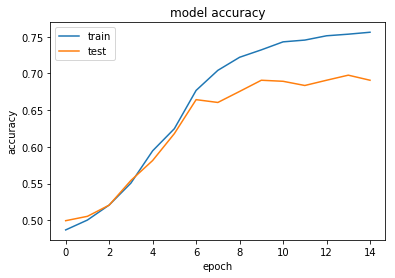

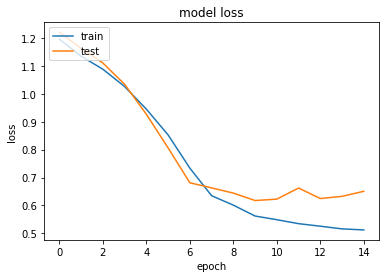

In [134]:
print('Vanilla lstm:')
plot_accuracy(vanilla_history)
plot_loss(vanilla_history)

Stacked lstm:


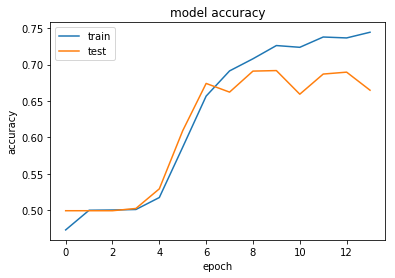

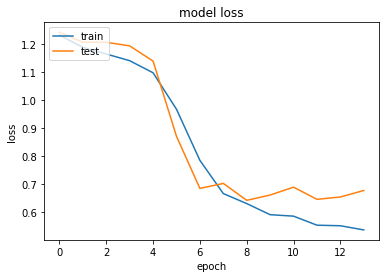

In [136]:
print('Stacked lstm:')
plot_accuracy(stacked_history)
plot_loss(stacked_history)

Bi lstm:


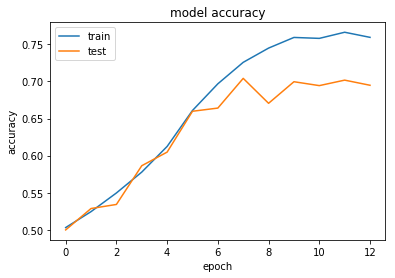

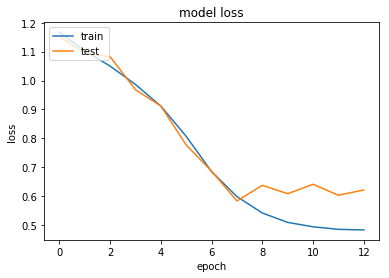

In [137]:
print('Bi lstm:')
plot_accuracy(bi_lstm_history)
plot_loss(bi_lstm_history)

In [138]:
from sklearn.metrics import classification_report

labels_true = pred_tensor_to_labels(y_test)
# vanilla
y_pred_vanilla = vanilla.predict(X_test)
labels_pred_vanilla = pred_tensor_to_labels(y_pred_vanilla)
# stacked
y_pred_stacked = stacked.predict(X_test)
labels_pred_stacked = pred_tensor_to_labels(y_pred_stacked)
# bilstm
y_pred_bi_lstm = bi_lstm.predict(X_test)
labels_pred_bi_lstm = pred_tensor_to_labels(y_pred_bi_lstm)

In [139]:
# removing U label for accuracy measures
true_labels_no_U = []
vanilla_pred_no_U = []
stacked_pred_no_U = []
bi_lstm_pred_no_U = []
for true_label, pred_vanilla, pred_stacked, pred_bi_lstm in zip(labels_true, labels_pred_vanilla, labels_pred_stacked, labels_pred_bi_lstm):
    if true_label != 'U':
        true_labels_no_U.append(true_label)
        vanilla_pred_no_U.append(pred_vanilla)
        stacked_pred_no_U.append(pred_stacked)
        bi_lstm_pred_no_U.append(pred_bi_lstm)

In [140]:
# ACCURACY
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# counted only for NB, PB, B true labels (U label is omitted)
acc_vanilla = accuracy_score(true_labels_no_U, vanilla_pred_no_U)
acc_stacked = accuracy_score(true_labels_no_U, stacked_pred_no_U)
acc_bi_lstm = accuracy_score(true_labels_no_U, bi_lstm_pred_no_U)
print("Accuracies:\nvanilla - {},\n stacked - {},\n bi-lstm - {}".format(acc_vanilla, acc_stacked, acc_bi_lstm))

Accuracies:
vanilla - 0.4148430066603235,
 stacked - 0.3591817316841104,
 bi-lstm - 0.41198858230256896


vanilla model:

Normalized confusion matrix
[[0.34 0.14 0.48 0.05]
 [0.15 0.28 0.4  0.17]
 [0.08 0.12 0.77 0.03]
 [0.   0.01 0.02 0.97]]


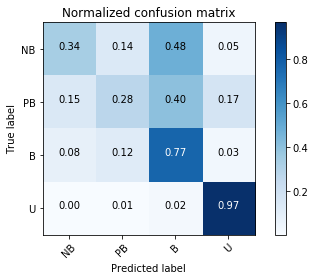

None
Classification report for eval data:
               precision    recall  f1-score   support

           B       0.60      0.34      0.43       745
          NB       0.60      0.28      0.38       858
          PB       0.35      0.77      0.48       499
           U       0.00      0.00      0.00         0

   micro avg       0.41      0.41      0.41      2102
   macro avg       0.39      0.35      0.32      2102
weighted avg       0.54      0.41      0.42      2102



/home/mariya/software/anaconda/envs/thesis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [141]:
print('vanilla model:\n')
print(cnf_matrix(labels_true, labels_pred_vanilla, ['NB', 'PB', 'B', 'U']))
clf_report(true_labels_no_U, vanilla_pred_no_U)

stacked model:

Normalized confusion matrix
[[0.01 0.49 0.46 0.05]
 [0.   0.47 0.37 0.16]
 [0.   0.25 0.7  0.04]
 [0.   0.01 0.02 0.97]]


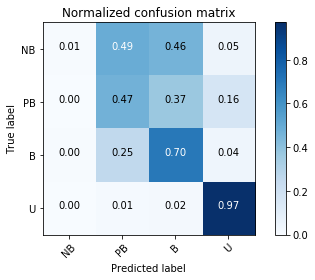

None
Classification report for eval data:
               precision    recall  f1-score   support

           B       0.67      0.01      0.01       745
          NB       0.45      0.47      0.46       858
          PB       0.35      0.70      0.46       499
           U       0.00      0.00      0.00         0

   micro avg       0.36      0.36      0.36      2102
   macro avg       0.37      0.29      0.23      2102
weighted avg       0.50      0.36      0.30      2102



In [142]:
print('stacked model:\n')
print(cnf_matrix(labels_true, labels_pred_stacked, ['NB', 'PB', 'B', 'U']))
clf_report(true_labels_no_U, stacked_pred_no_U)

bi lstm model:

Normalized confusion matrix
[[0.12 0.4  0.46 0.02]
 [0.04 0.48 0.35 0.14]
 [0.02 0.22 0.74 0.02]
 [0.   0.   0.02 0.98]]


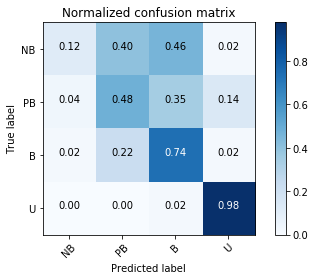

None
Classification report for eval data:
               precision    recall  f1-score   support

           B       0.68      0.12      0.20       745
          NB       0.50      0.48      0.49       858
          PB       0.37      0.74      0.49       499
           U       0.00      0.00      0.00         0

   micro avg       0.41      0.41      0.41      2102
   macro avg       0.39      0.33      0.29      2102
weighted avg       0.53      0.41      0.39      2102



In [143]:
print('bi lstm model:\n')
print(cnf_matrix(labels_true, labels_pred_bi_lstm, ['NB', 'PB', 'B', 'U']))
clf_report(true_labels_no_U, bi_lstm_pred_no_U)